# Calculate Pivot Points

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from pandas import Timestamp
import datetime as dt

Configurations

In [21]:
symbol = '^NSEBANK'

period = "1y"
interval= "1d"

# period = "1mo"
# interval = "15m"

Data Collection

In [4]:
def get_stock_price(symbol):
    df = yf.download(symbol, period=period, interval=interval)
    df['Date'] = pd.to_datetime(df.index)
    df['Date'] = df['Date'].apply(mpl_dates.date2num)
    df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
    return df

In [ ]:
df = get_stock_price(symbol)
df.tail()

In [ ]:
df2 = df.resample('M').agg({'Open':'first', 'High':'max', 'Low': 'min', 'Close':'last'})
print(df2.tail())

df3 = df.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 'Close':'last'})
print(df3.tail())

df['52W H'] = df['High'].rolling(window=252, center=False).max()
df['52W L'] = df['Low'].rolling(window=252, center=False).min()

print(df['52W H'].tail())
print(df['52W L'].tail())

1. Fractal candlestick pattern
There are actually a few ways to do it. In his amazingly helpful article, Giancula is using fractal candlestick pattern to detect the pivot points which then become the support or resistance levels. Take 5 candles, if the candle in the middle has the highest high and the 2nd and 4th candle have lower highs, we have a bearish fractal or a resistance level. Vice versa for a bullish fractal.

In [ ]:
def support(df, index, n1, n2): #n1 n2 before and after candle l
    for i in range(index-n1+1, index+1):
        if(df['Low'][i]>df['Low'][i-1]):
            return False
    for i in range(index+1,index+n2+1):
        if(df['Low'][i]<df['Low'][i-1]):
            return False
    return True

#support(df,46,3,2)

def resistance(df, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df['High'][i]<df['High'][i-1]):
            return False
    for i in range(l+1,l+n2+1):
        if(df['High'][i]>df['High'][i-1]):
            return False
    return True
#resistance(df, 30, 3, 5)


#method 1: fractal candlestick pattern
# determine bullish fractal 
def is_support(df,i):  
  cond1 = df['Low'][i] < df['Low'][i-1]   
  cond2 = df['Low'][i] < df['Low'][i+1]   
  cond3 = df['Low'][i+1] < df['Low'][i+2]   
  cond4 = df['Low'][i-1] < df['Low'][i-2]  
  return (cond1 and cond2 and cond3 and cond4) 
# determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['High'][i] > df['High'][i-1]   
  cond2 = df['High'][i] > df['High'][i+1]   
  cond3 = df['High'][i+1] > df['High'][i+2]   
  cond4 = df['High'][i-1] > df['High'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)
# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df): 
  ave =  np.mean(df['High'] - df['Low'])    
  return np.sum([abs(value-level)<ave for _,level in levels])==0
      
#method 1: fractal candlestick pattern
def detect_level_method_1(df):
  levels = []  
  indexes = list(df.index.values)
  for i in range(2,df.shape[0]-2):
    index = Timestamp(indexes[i])
    if is_support(df,i):
      l = df['Low'][i]
      if is_far_from_level(l, levels, df):
        levels.append((index,l))
    elif is_resistance(df,i):
      l = df['High'][i]
      if is_far_from_level(l, levels, df):
        levels.append((index,l))
  return levels

def detect_level_method_1_1(df):
  levels = []  
  indexes = list(df.index.values)
  for i in range(2,df.shape[0]-2):
    index = Timestamp(indexes[i])
    if support(df,i, 2, 2):
      l = df['Low'][i]
      if is_far_from_level(l, levels, df):
        levels.append((index,l))
    elif resistance(df,i, 2, 2):
      l = df['High'][i]
      if is_far_from_level(l, levels, df):
        levels.append((index,l))
  return levels
      
print(detect_level_method_1(df))
print(detect_level_method_1_1(df))

In [ ]:
#method 2: window shifting method
def detect_level_method_2(df, window=5):
  levels = []
  max_list = []
  min_list = []
  for i in range(window, len(df)-window):
      high_range = df['High'][i-window:i+window-1]
      current_max = high_range.max()
      if current_max not in max_list:
          max_list = []
      max_list.append(current_max)
      if len(max_list) == window and is_far_from_level(current_max, levels, df):
          levels.append((high_range.idxmax(), current_max))
      
      low_range = df['Low'][i-window:i+window]
      current_min = low_range.min()
      if current_min not in min_list:
          min_list = []
      min_list.append(current_min)
      if len(min_list) == window and is_far_from_level(current_min, levels, df):
          levels.append((low_range.idxmin(), current_min))
  return levels

print(detect_level_method_2(df, 4))

In [ ]:
df = get_stock_price(symbol)

all_pivots_dict = []
all_pivots = []
levels = detect_level_method_1(df)
for level in levels:
    point = np.round(level[1], 2)
    
    pivot = {}
    pivot["date"]=level[0].to_pydatetime()
    pivot["level"] = point
    all_pivots_dict.append(pivot)
    
    all_pivots.append(point)

levels = detect_level_method_2(df)
for level in levels:
    point = np.round(level[1], 2)
    
    pivot = {}
    pivot["date"]=level[0].to_pydatetime()
    pivot["level"] = point
    all_pivots_dict.append(pivot)
    
    all_pivots.append(point)

all_pivots = [*set(all_pivots)]
all_pivots.sort()
print(all_pivots)
print(all_pivots_dict)

In [61]:
# for visualization
def plot_all(levels, df):    
  fig, ax = plt.subplots(figsize=(16, 9))   
  candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)    
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)    
  for level in levels:        
    plt.hlines(level[1], xmin = df['Date'][level[0]], xmax = max(df['Date']), colors='blue', linestyle='--')    
  fig.show()

[*********************100%***********************]  1 of 1 completed


C:\Users\Sachin\AppData\Local\Temp\2\ipykernel_8248\2726700584.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


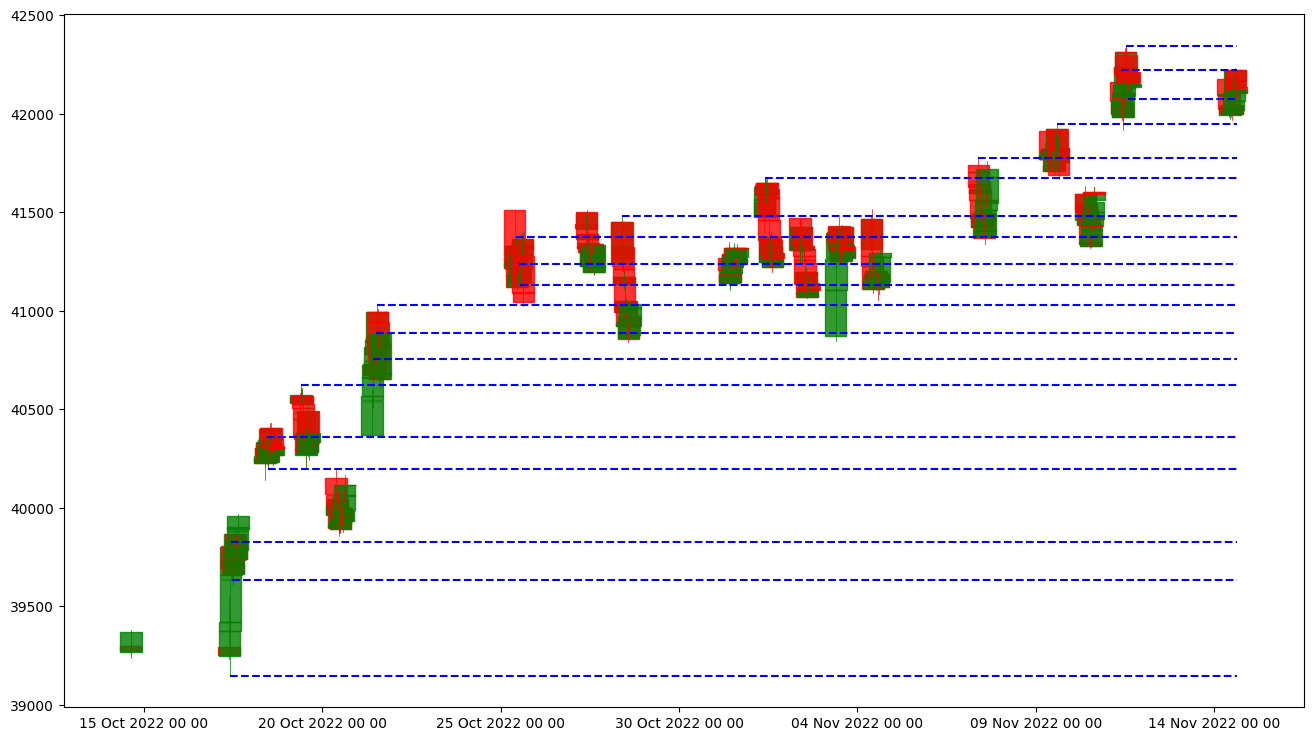

In [60]:
df = get_stock_price(symbol)
levels = detect_level_method_1(df)
plot_all(levels, df)